In [1]:
import joblib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV,train_test_split,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import csv
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,make_scorer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [3]:
data = pd.read_csv(r"C:\Users\bett0\sleeping-sickness-prediction\Sleep_health_and_lifestyle_dataset.csv")

Cinsiyet: Bireyin cinsiyeti (örneğin, Erkek, Kadın).
Yaş: Bireyin yaşı.
Meslek: Kişinin işi veya mesleği.
Uyku Süresi: Kişinin gecede ortalama uyku süresi.
Uyku Kalitesi: Uykunun kalitesini belirten bir değer.
Fiziksel Aktivite Seviyesi: Kişinin fiziksel aktivite düzeyi.
Stres Seviyesi: Bireyin stres seviyesi.
BMI Kategorisi: Beden kitle indeksi (BMI) kategorisi (örneğin, Normal, Aşırı Kilolu, Obez).
Kan Basıncı: Kişinin kan basıncı değeri.
Kalp Atış Hızı: Kişinin kalp atış hızı.
Günlük Adımlar: Kişinin günlük attığı adım sayısı.
Uyku Bozukluğu: Uyku bozukluğu olup olmadığını belirten bir değer.

In [4]:

################################################
# 1. Exploratory Data Analysis
################################################

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())


check_df(data)

##################### Shape #####################
(374, 13)
##################### Types #####################
Person ID                    int64
Gender                      object
Age                          int64
Occupation                  object
Sleep Duration             float64
Quality of Sleep             int64
Physical Activity Level      int64
Stress Level                 int64
BMI Category                object
Blood Pressure              object
Heart Rate                   int64
Daily Steps                  int64
Sleep Disorder              object
dtype: object
##################### Head #####################
   Person ID Gender  Age            Occupation  Sleep Duration  Quality of Sleep  Physical Activity Level  Stress Level BMI Category Blood Pressure  Heart Rate  Daily Steps Sleep Disorder
0          1   Male   27     Software Engineer             6.1                 6                       42             6   Overweight         126/83          77         4200            

In [5]:
data['Sleep Disorder'] = data['Sleep Disorder'].fillna('No')
data.isnull().sum()

Person ID                  0
Gender                     0
Age                        0
Occupation                 0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
BMI Category               0
Blood Pressure             0
Heart Rate                 0
Daily Steps                0
Sleep Disorder             0
dtype: int64

In [6]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


In [7]:
def grab_col_names(dataframe, cat_th=5, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


In [8]:
cat_cols, num_cols, cat_but_car = grab_col_names(data)

num_cols = [col for col in num_cols if col != "Person ID"]


        Gender      Ratio
Gender                   
Male       189  50.534759
Female     185  49.465241
##########################################
                      Occupation      Ratio
Occupation                                 
Nurse                         73  19.518717
Doctor                        71  18.983957
Engineer                      63  16.844920
Lawyer                        47  12.566845
Teacher                       40  10.695187
Accountant                    37   9.893048
Salesperson                   32   8.556150
Software Engineer              4   1.069519
Scientist                      4   1.069519
Sales Representative           2   0.534759
Manager                        1   0.267380
##########################################
               BMI Category      Ratio
BMI Category                          
Normal                  195  52.139037
Overweight              148  39.572193
Normal Weight            21   5.614973
Obese                    10   2.673797
####

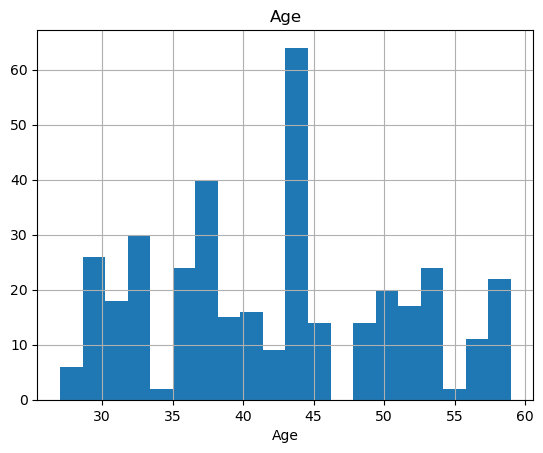

count    374.000000
mean       7.132086
std        0.795657
min        5.800000
5%         6.000000
10%        6.100000
20%        6.300000
30%        6.500000
40%        6.800000
50%        7.200000
60%        7.380000
70%        7.700000
80%        7.900000
90%        8.200000
95%        8.400000
99%        8.500000
max        8.500000
Name: Sleep Duration, dtype: float64


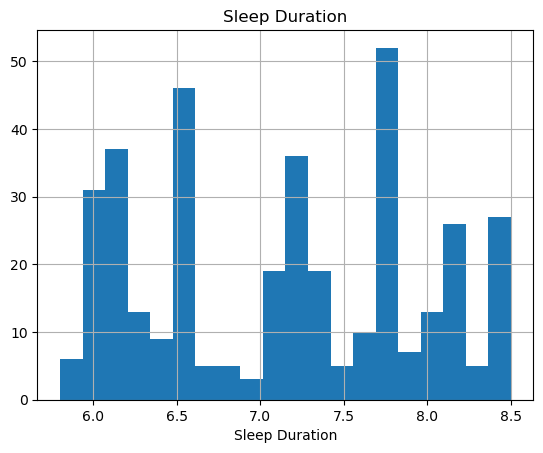

count    374.000000
mean       7.312834
std        1.196956
min        4.000000
5%         6.000000
10%        6.000000
20%        6.000000
30%        6.000000
40%        7.000000
50%        7.000000
60%        8.000000
70%        8.000000
80%        8.000000
90%        9.000000
95%        9.000000
99%        9.000000
max        9.000000
Name: Quality of Sleep, dtype: float64


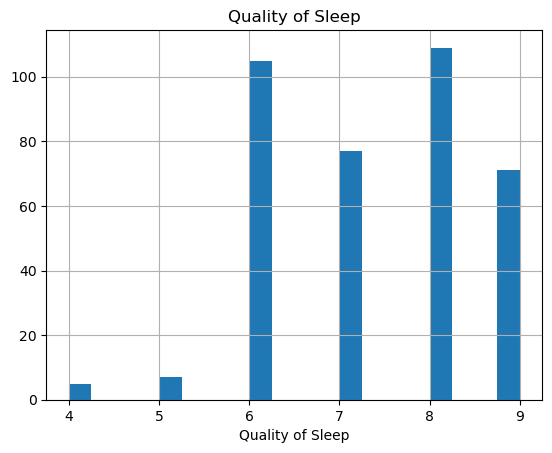

count    374.000000
mean      59.171123
std       20.830804
min       30.000000
5%        30.000000
10%       30.000000
20%       40.000000
30%       45.000000
40%       45.400000
50%       60.000000
60%       60.000000
70%       75.000000
80%       75.000000
90%       90.000000
95%       90.000000
99%       90.000000
max       90.000000
Name: Physical Activity Level, dtype: float64


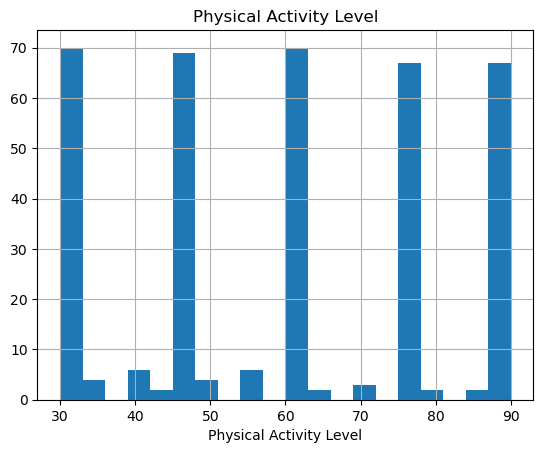

count    374.000000
mean       5.385027
std        1.774526
min        3.000000
5%         3.000000
10%        3.000000
20%        4.000000
30%        4.000000
40%        5.000000
50%        5.000000
60%        6.000000
70%        7.000000
80%        7.000000
90%        8.000000
95%        8.000000
99%        8.000000
max        8.000000
Name: Stress Level, dtype: float64


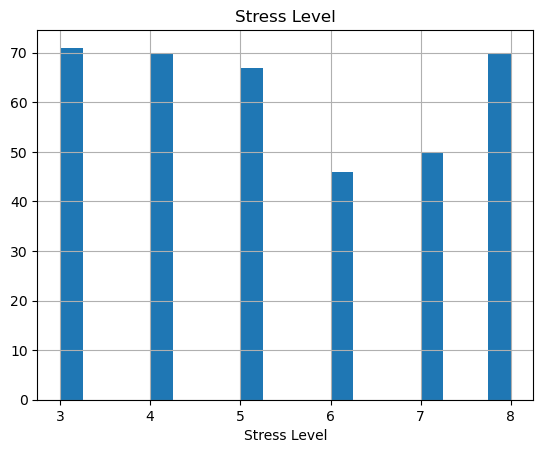

count    374.000000
mean      70.165775
std        4.135676
min       65.000000
5%        65.000000
10%       65.000000
20%       68.000000
30%       68.000000
40%       68.000000
50%       70.000000
60%       70.000000
70%       72.000000
80%       72.000000
90%       75.000000
95%       78.000000
99%       85.000000
max       86.000000
Name: Heart Rate, dtype: float64


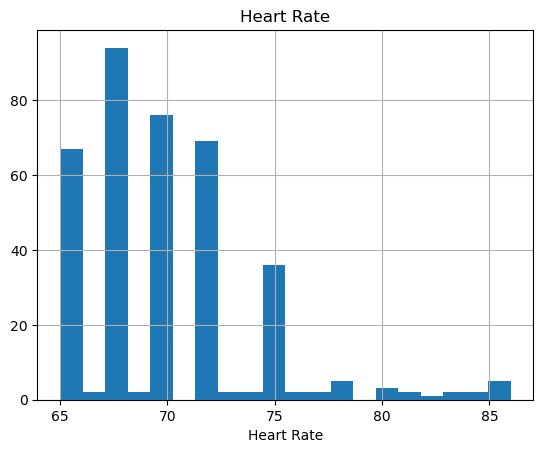

count      374.000000
mean      6816.844920
std       1617.915679
min       3000.000000
5%        4930.000000
10%       5000.000000
20%       5000.000000
30%       6000.000000
40%       6000.000000
50%       7000.000000
60%       7000.000000
70%       8000.000000
80%       8000.000000
90%       8000.000000
95%      10000.000000
99%      10000.000000
max      10000.000000
Name: Daily Steps, dtype: float64


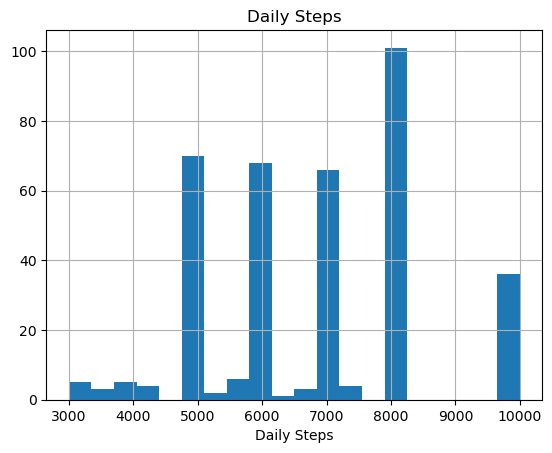

                      Age
Sleep Disorder           
Insomnia        43.519481
No              39.036530
Sleep Apnea     49.705128


                Sleep Duration
Sleep Disorder                
Insomnia              6.589610
No                    7.358447
Sleep Apnea           7.032051


                Quality of Sleep
Sleep Disorder                  
Insomnia                6.532468
No                      7.625571
Sleep Apnea             7.205128


                Physical Activity Level
Sleep Disorder                         
Insomnia                      46.818182
No                            57.949772
Sleep Apnea                   74.794872


                Stress Level
Sleep Disorder              
Insomnia            5.870130
No                  5.114155
Sleep Apnea         5.666667


                Heart Rate
Sleep Disorder            
Insomnia         70.467532
No               69.018265
Sleep Apnea      73.089744


                Daily Steps
Sleep Disorder             
In

In [9]:

# Kategorik değişkenlerin incelenmesi
for col in cat_cols:
    cat_summary(data, col)

# Sayısal değişkenlerin incelenmesi
data[num_cols].describe().T

for col in num_cols:
   num_summary(data, col, plot=True)

# Target ile sayısal değişkenlerin incelemesi
for col in num_cols:
    target_summary_with_num(data, "Sleep Disorder", col)

In [10]:
print(num_cols)
print(cat_cols)

['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps']
['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']


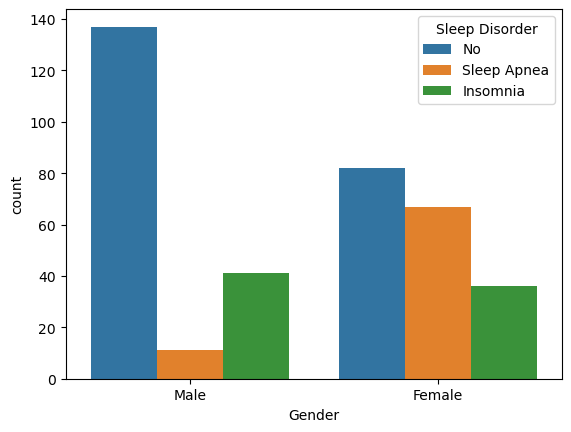

In [11]:
sns.countplot(x='Gender', hue='Sleep Disorder', data=data)
plt.show()

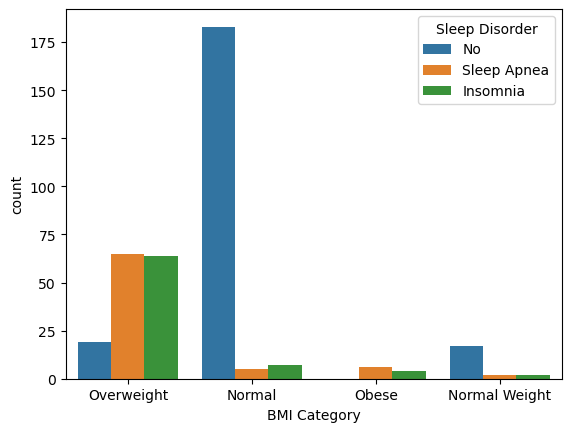

In [12]:
sns.countplot(x='BMI Category', hue='Sleep Disorder', data=data)
plt.show()


In [13]:
data.head()
data.shape

(374, 13)

In [14]:
################################################
# 2. FEATURE ENGINEERİNG
################################################

# 'Blood Pressure' sütununu kullanarak kan basıncı kategorileri oluşturun
def categorize_blood_pressure(bp):
    systolic, diastolic = map(int, bp.split('/'))

    if systolic < 120 and diastolic < 80:
        return 'Normal'
    elif 120 <= systolic <= 129 and diastolic < 80:
        return 'Elevated'
    elif 130 <= systolic <= 139 or 80 <= diastolic <= 89:
        return 'High Blood Pressure '
    elif systolic >= 140 or diastolic >= 90:
        return 'High Blood Pressure '
    else:
        return 'Hypertensive Crisis'

data['Blood Pressure Category'] = data['Blood Pressure'].apply(categorize_blood_pressure)


# 'Blood Pressure' sütununu '/' karakterine göre böler ve 'SYSTOLIC' ile 'DIASTOLIC' sütunlarını oluşturur
data[['SYSTOLIC', 'DIASTOLIC']] = data['Blood Pressure'].str.split('/', expand=True)

data = data.drop("Blood Pressure", axis = 1)
# 'Sleep Duration' ve 'Quality of Sleep' değişkenlerini kullanarak toplam bir uyku kalite skoru oluşturun
data['Sleep Quality Score'] = data['Sleep Duration'] * data['Quality of Sleep']

# 'Physical Activity Level' ve 'Daily Steps' değişkenlerini kullanarak genel bir fiziksel aktivite skoru hesaplayın
data['Activity Score'] = data['Physical Activity Level'] * data['Daily Steps']


# Değişken isimleri büyütmek
data.columns = [col.upper() for col in data.columns]

# Age
data.loc[(data['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
data.loc[(data['AGE'] >= 35) & (data['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
data.loc[(data['AGE'] > 55), "NEW_AGE_CAT"] = 'old'
data.head()


,PERSON ID,GENDER,AGE,OCCUPATION,SLEEP DURATION,QUALITY OF SLEEP,PHYSICAL ACTIVITY LEVEL,STRESS LEVEL,BMI CATEGORY,HEART RATE,DAILY STEPS,SLEEP DISORDER,BLOOD PRESSURE CATEGORY,SYSTOLIC,DIASTOLIC,SLEEP QUALITY SCORE,ACTIVITY SCORE,NEW_AGE_CAT
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,No,High Blood Pressure,126,83,36.6,176400,young
1,2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,No,High Blood Pressure,125,80,37.2,600000,young
2,3,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,No,High Blood Pressure,125,80,37.2,600000,young
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,High Blood Pressure,140,90,23.6,90000,young
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,High Blood Pressure,140,90,23.6,90000,young


In [15]:
data.dtypes

data['SYSTOLIC'] = pd.to_numeric(data['SYSTOLIC'], errors='coerce')
data["DIASTOLIC"] = pd.to_numeric(data['DIASTOLIC'], errors='coerce')

In [16]:
cat_cols, num_cols, cat_but_car = grab_col_names(data)

In [17]:
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    outliers = dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)]
    return outliers

for col in num_cols:
    outliers_df = check_outlier(data, col)
    if not outliers_df.empty:
        print(f"Aykırı Değerler Var - Sütun: {col}")
        print(outliers_df)
    else:
        print(f"Aykırı Değer Yok - Sütun: {col}")


Aykırı Değer Yok - Sütun: PERSON ID
Aykırı Değer Yok - Sütun: AGE
Aykırı Değer Yok - Sütun: SLEEP DURATION
Aykırı Değer Yok - Sütun: QUALITY OF SLEEP
Aykırı Değer Yok - Sütun: PHYSICAL ACTIVITY LEVEL
Aykırı Değer Yok - Sütun: STRESS LEVEL
Aykırı Değer Yok - Sütun: HEART RATE
Aykırı Değer Yok - Sütun: DAILY STEPS
Aykırı Değer Yok - Sütun: SYSTOLIC
Aykırı Değer Yok - Sütun: DIASTOLIC
Aykırı Değer Yok - Sütun: SLEEP QUALITY SCORE
Aykırı Değer Yok - Sütun: ACTIVITY SCORE


In [18]:
data = data.drop("PERSON ID",axis =1)

In [19]:

data.duplicated().sum()

242

In [20]:
cat_cols, num_cols, cat_but_car = grab_col_names(data)

In [21]:
print(num_cols)

['AGE', 'SLEEP DURATION', 'QUALITY OF SLEEP', 'PHYSICAL ACTIVITY LEVEL', 'STRESS LEVEL', 'HEART RATE', 'DAILY STEPS', 'SYSTOLIC', 'DIASTOLIC', 'SLEEP QUALITY SCORE', 'ACTIVITY SCORE']


In [22]:
print(cat_cols)

['GENDER', 'OCCUPATION', 'BMI CATEGORY', 'SLEEP DISORDER', 'BLOOD PRESSURE CATEGORY', 'NEW_AGE_CAT']


In [23]:
data.dtypes

GENDER                      object
AGE                          int64
OCCUPATION                  object
SLEEP DURATION             float64
QUALITY OF SLEEP             int64
PHYSICAL ACTIVITY LEVEL      int64
STRESS LEVEL                 int64
BMI CATEGORY                object
HEART RATE                   int64
DAILY STEPS                  int64
SLEEP DISORDER              object
BLOOD PRESSURE CATEGORY     object
SYSTOLIC                     int64
DIASTOLIC                    int64
SLEEP QUALITY SCORE        float64
ACTIVITY SCORE               int64
NEW_AGE_CAT                 object
dtype: object

In [24]:

print(cat_cols)
print(num_cols)
print(data.head())

['GENDER', 'OCCUPATION', 'BMI CATEGORY', 'SLEEP DISORDER', 'BLOOD PRESSURE CATEGORY', 'NEW_AGE_CAT']
['AGE', 'SLEEP DURATION', 'QUALITY OF SLEEP', 'PHYSICAL ACTIVITY LEVEL', 'STRESS LEVEL', 'HEART RATE', 'DAILY STEPS', 'SYSTOLIC', 'DIASTOLIC', 'SLEEP QUALITY SCORE', 'ACTIVITY SCORE']
  GENDER  AGE            OCCUPATION  SLEEP DURATION  QUALITY OF SLEEP  PHYSICAL ACTIVITY LEVEL  STRESS LEVEL BMI CATEGORY  HEART RATE  DAILY STEPS SLEEP DISORDER BLOOD PRESSURE CATEGORY  SYSTOLIC  DIASTOLIC  SLEEP QUALITY SCORE  ACTIVITY SCORE NEW_AGE_CAT
0   Male   27     Software Engineer             6.1                 6                       42             6   Overweight          77         4200             No    High Blood Pressure        126         83                 36.6          176400       young
1   Male   28                Doctor             6.2                 6                       60             8       Normal          75        10000             No    High Blood Pressure        125        

In [25]:
for col in cat_cols:
    unique_occupations = data[col].unique()
    print(unique_occupations)


['Male' 'Female']
['Software Engineer' 'Doctor' 'Sales Representative' 'Teacher' 'Nurse'
 'Engineer' 'Accountant' 'Scientist' 'Lawyer' 'Salesperson' 'Manager']
['Overweight' 'Normal' 'Obese' 'Normal Weight']
['No' 'Sleep Apnea' 'Insomnia']
['High Blood Pressure ' 'Normal' 'Elevated']
['young' 'middleage' 'old']


In [26]:
#data = data.drop_duplicates()

In [27]:
#data.drop_duplicates(keep="last", inplace=True)


In [28]:
data.head()

,GENDER,AGE,OCCUPATION,SLEEP DURATION,QUALITY OF SLEEP,PHYSICAL ACTIVITY LEVEL,STRESS LEVEL,BMI CATEGORY,HEART RATE,DAILY STEPS,SLEEP DISORDER,BLOOD PRESSURE CATEGORY,SYSTOLIC,DIASTOLIC,SLEEP QUALITY SCORE,ACTIVITY SCORE,NEW_AGE_CAT
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,No,High Blood Pressure,126,83,36.6,176400,young
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,No,High Blood Pressure,125,80,37.2,600000,young
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,No,High Blood Pressure,125,80,37.2,600000,young
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,High Blood Pressure,140,90,23.6,90000,young
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,High Blood Pressure,140,90,23.6,90000,young


In [29]:
#data.drop_duplicates(keep="last", inplace=True)

In [30]:
# "Sleep Disorder" sütununu kategorik olarak kodlayın
data["SLEEP DISORDER"] = data["SLEEP DISORDER"].map({"Insomnia": 1, "Sleep Apnea": 2, "No": 0})


import pickle
ohe_columns = ['OCCUPATION', 'BMI CATEGORY', 'BLOOD PRESSURE CATEGORY', 'NEW_AGE_CAT']
num_cols = ['AGE', 'SLEEP DURATION', 'QUALITY OF SLEEP', 'PHYSICAL ACTIVITY LEVEL', 'STRESS LEVEL', 'HEART RATE', 'DAILY STEPS', 'SYSTOLIC', 'DIASTOLIC', 'SLEEP QUALITY SCORE', 'ACTIVITY SCORE']

scale = StandardScaler()
data[num_cols] = scale.fit_transform(data[num_cols])


# 'Gender' sütununu label encode et
label = LabelEncoder()
data['GENDER'] = label.fit_transform(data['GENDER'])
with open('label_encoder.pkl', 'wb') as le_file:
    pickle.dump(label, le_file)



# One-Hot Encoder'ı tanımlayın
encoder = OneHotEncoder()

# Kullanıcı verilerine One-Hot Encoding uygulayın
encoded_data = encoder.fit_transform(data[ohe_columns])  # user_data, kullanıcıdan alınan verilerdir

# One-Hot Encoding sonrası sütun isimlerini alın
encoded_columns = encoder.get_feature_names_out(input_features=ohe_columns)

# One-Hot Encoding sonrası veriyi DataFrame'e dönüştürün
encoded_data = pd.DataFrame(encoded_data.toarray(), columns=encoded_columns) # OneHotEncoder'ı kaydet
with open('encoded_data.pkl', 'wb') as ohe_file:
    pickle.dump(encoder, ohe_file)  

In [31]:
encoded_data.columns

Index(['OCCUPATION_Accountant', 'OCCUPATION_Doctor', 'OCCUPATION_Engineer', 'OCCUPATION_Lawyer', 'OCCUPATION_Manager', 'OCCUPATION_Nurse', 'OCCUPATION_Sales Representative', 'OCCUPATION_Salesperson', 'OCCUPATION_Scientist', 'OCCUPATION_Software Engineer', 'OCCUPATION_Teacher', 'BMI CATEGORY_Normal', 'BMI CATEGORY_Normal Weight', 'BMI CATEGORY_Obese', 'BMI CATEGORY_Overweight', 'BLOOD PRESSURE CATEGORY_Elevated', 'BLOOD PRESSURE CATEGORY_High Blood Pressure ', 'BLOOD PRESSURE CATEGORY_Normal',
       'NEW_AGE_CAT_middleage', 'NEW_AGE_CAT_old', 'NEW_AGE_CAT_young'],
      dtype='object')

In [32]:
encoded_data.isnull().sum()

OCCUPATION_Accountant                           0
OCCUPATION_Doctor                               0
OCCUPATION_Engineer                             0
OCCUPATION_Lawyer                               0
OCCUPATION_Manager                              0
OCCUPATION_Nurse                                0
OCCUPATION_Sales Representative                 0
OCCUPATION_Salesperson                          0
OCCUPATION_Scientist                            0
OCCUPATION_Software Engineer                    0
OCCUPATION_Teacher                              0
BMI CATEGORY_Normal                             0
BMI CATEGORY_Normal Weight                      0
BMI CATEGORY_Obese                              0
BMI CATEGORY_Overweight                         0
BLOOD PRESSURE CATEGORY_Elevated                0
BLOOD PRESSURE CATEGORY_High Blood Pressure     0
BLOOD PRESSURE CATEGORY_Normal                  0
NEW_AGE_CAT_middleage                           0
NEW_AGE_CAT_old                                 0


In [33]:
# One-Hot Encoding sonrasında NaN değerlere sahip sütunları kontrol et
nan_columns = encoded_data.columns[encoded_data.isnull().any()]
print("NaN Değerlere Sahip Sütunlar:")
print(nan_columns)

# NaN değerlere sahip sütunlardaki benzersiz değerleri kontrol et
for column in nan_columns:
    unique_values = data[column.replace('x0_', '')].unique()
    print(f"{column}: {unique_values}")


NaN Değerlere Sahip Sütunlar:
Index([], dtype='object')


In [34]:
data.isnull().sum()

GENDER                     0
AGE                        0
OCCUPATION                 0
SLEEP DURATION             0
QUALITY OF SLEEP           0
PHYSICAL ACTIVITY LEVEL    0
STRESS LEVEL               0
BMI CATEGORY               0
HEART RATE                 0
DAILY STEPS                0
SLEEP DISORDER             0
BLOOD PRESSURE CATEGORY    0
SYSTOLIC                   0
DIASTOLIC                  0
SLEEP QUALITY SCORE        0
ACTIVITY SCORE             0
NEW_AGE_CAT                0
dtype: int64

In [35]:
data.reset_index(drop=True, inplace=True)
encoded_data.reset_index(drop=True, inplace=True)


In [36]:
# One-Hot Encoding sonrası sütun isimlerini ve veriyi birleştir
data = pd.concat([data.drop(ohe_columns, axis=1), encoded_data], axis=1)

In [37]:
data.head()

,GENDER,AGE,SLEEP DURATION,QUALITY OF SLEEP,PHYSICAL ACTIVITY LEVEL,STRESS LEVEL,HEART RATE,DAILY STEPS,SLEEP DISORDER,SYSTOLIC,DIASTOLIC,SLEEP QUALITY SCORE,ACTIVITY SCORE,OCCUPATION_Accountant,OCCUPATION_Doctor,OCCUPATION_Engineer,OCCUPATION_Lawyer,OCCUPATION_Manager,OCCUPATION_Nurse,OCCUPATION_Sales Representative,OCCUPATION_Salesperson,OCCUPATION_Scientist,OCCUPATION_Software Engineer,OCCUPATION_Teacher,BMI CATEGORY_Normal,BMI CATEGORY_Normal Weight,BMI CATEGORY_Obese,BMI CATEGORY_Overweight,BLOOD PRESSURE CATEGORY_Elevated,BLOOD PRESSURE CATEGORY_High Blood Pressure,BLOOD PRESSURE CATEGORY_Normal,NEW_AGE_CAT_middleage,NEW_AGE_CAT_old,NEW_AGE_CAT_young
0,1,-1.753096,-1.298887,-1.098280,-0.825418,0.347021,1.654719,-1.619584,0,-0.330002,-0.268102,-1.178322,-1.093115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,0,-0.459239,-0.755640,-1.135199,0.737579,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,0,-0.459239,-0.755640,-1.135199,0.737579,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,2,1.479309,0.869486,-2.112662,-1.466515,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,2,1.479309,0.869486,-2.112662,-1.466515,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [38]:
data.isnull().sum()

GENDER                                          0
AGE                                             0
SLEEP DURATION                                  0
QUALITY OF SLEEP                                0
PHYSICAL ACTIVITY LEVEL                         0
STRESS LEVEL                                    0
HEART RATE                                      0
DAILY STEPS                                     0
SLEEP DISORDER                                  0
SYSTOLIC                                        0
DIASTOLIC                                       0
SLEEP QUALITY SCORE                             0
ACTIVITY SCORE                                  0
OCCUPATION_Accountant                           0
OCCUPATION_Doctor                               0
OCCUPATION_Engineer                             0
OCCUPATION_Lawyer                               0
OCCUPATION_Manager                              0
OCCUPATION_Nurse                                0
OCCUPATION_Sales Representative                 0


In [39]:
data.columns

Index(['GENDER', 'AGE', 'SLEEP DURATION', 'QUALITY OF SLEEP', 'PHYSICAL ACTIVITY LEVEL', 'STRESS LEVEL', 'HEART RATE', 'DAILY STEPS', 'SLEEP DISORDER', 'SYSTOLIC', 'DIASTOLIC', 'SLEEP QUALITY SCORE', 'ACTIVITY SCORE', 'OCCUPATION_Accountant', 'OCCUPATION_Doctor', 'OCCUPATION_Engineer', 'OCCUPATION_Lawyer', 'OCCUPATION_Manager', 'OCCUPATION_Nurse', 'OCCUPATION_Sales Representative', 'OCCUPATION_Salesperson', 'OCCUPATION_Scientist', 'OCCUPATION_Software Engineer', 'OCCUPATION_Teacher',
       'BMI CATEGORY_Normal', 'BMI CATEGORY_Normal Weight', 'BMI CATEGORY_Obese', 'BMI CATEGORY_Overweight', 'BLOOD PRESSURE CATEGORY_Elevated', 'BLOOD PRESSURE CATEGORY_High Blood Pressure ', 'BLOOD PRESSURE CATEGORY_Normal', 'NEW_AGE_CAT_middleage', 'NEW_AGE_CAT_old', 'NEW_AGE_CAT_young'],
      dtype='object')

In [40]:
data.columns

Index(['GENDER', 'AGE', 'SLEEP DURATION', 'QUALITY OF SLEEP', 'PHYSICAL ACTIVITY LEVEL', 'STRESS LEVEL', 'HEART RATE', 'DAILY STEPS', 'SLEEP DISORDER', 'SYSTOLIC', 'DIASTOLIC', 'SLEEP QUALITY SCORE', 'ACTIVITY SCORE', 'OCCUPATION_Accountant', 'OCCUPATION_Doctor', 'OCCUPATION_Engineer', 'OCCUPATION_Lawyer', 'OCCUPATION_Manager', 'OCCUPATION_Nurse', 'OCCUPATION_Sales Representative', 'OCCUPATION_Salesperson', 'OCCUPATION_Scientist', 'OCCUPATION_Software Engineer', 'OCCUPATION_Teacher',
       'BMI CATEGORY_Normal', 'BMI CATEGORY_Normal Weight', 'BMI CATEGORY_Obese', 'BMI CATEGORY_Overweight', 'BLOOD PRESSURE CATEGORY_Elevated', 'BLOOD PRESSURE CATEGORY_High Blood Pressure ', 'BLOOD PRESSURE CATEGORY_Normal', 'NEW_AGE_CAT_middleage', 'NEW_AGE_CAT_old', 'NEW_AGE_CAT_young'],
      dtype='object')

In [41]:


column_order = [
    "GENDER", "AGE", "SLEEP DURATION", "QUALITY OF SLEEP", "PHYSICAL ACTIVITY LEVEL", 
    "STRESS LEVEL", "HEART RATE", "DAILY STEPS", "SLEEP DISORDER", "SYSTOLIC", 
    "DIASTOLIC", "SLEEP QUALITY SCORE", "ACTIVITY SCORE", "OCCUPATION_Accountant", 
    "OCCUPATION_Doctor", "OCCUPATION_Engineer", "OCCUPATION_Lawyer", 
    "OCCUPATION_Manager", "OCCUPATION_Nurse", "OCCUPATION_Sales Representative", 
    "OCCUPATION_Salesperson", "OCCUPATION_Scientist", "OCCUPATION_Software Engineer", 
    "OCCUPATION_Teacher", "BMI CATEGORY_Normal", "BMI CATEGORY_Normal Weight", 
    "BMI CATEGORY_Obese", "BMI CATEGORY_Overweight", 
    "BLOOD PRESSURE CATEGORY_Elevated", "BLOOD PRESSURE CATEGORY_High Blood Pressure ",
    "BLOOD PRESSURE CATEGORY_Normal", "NEW_AGE_CAT_middleage", "NEW_AGE_CAT_old", 
    "NEW_AGE_CAT_young"
]

# Modeldeki sıralamayı temsil eden column_order listesini kullanarak sıralama yapın
data = data[column_order]

In [42]:
data.head()

,GENDER,AGE,SLEEP DURATION,QUALITY OF SLEEP,PHYSICAL ACTIVITY LEVEL,STRESS LEVEL,HEART RATE,DAILY STEPS,SLEEP DISORDER,SYSTOLIC,DIASTOLIC,SLEEP QUALITY SCORE,ACTIVITY SCORE,OCCUPATION_Accountant,OCCUPATION_Doctor,OCCUPATION_Engineer,OCCUPATION_Lawyer,OCCUPATION_Manager,OCCUPATION_Nurse,OCCUPATION_Sales Representative,OCCUPATION_Salesperson,OCCUPATION_Scientist,OCCUPATION_Software Engineer,OCCUPATION_Teacher,BMI CATEGORY_Normal,BMI CATEGORY_Normal Weight,BMI CATEGORY_Obese,BMI CATEGORY_Overweight,BLOOD PRESSURE CATEGORY_Elevated,BLOOD PRESSURE CATEGORY_High Blood Pressure,BLOOD PRESSURE CATEGORY_Normal,NEW_AGE_CAT_middleage,NEW_AGE_CAT_old,NEW_AGE_CAT_young
0,1,-1.753096,-1.298887,-1.098280,-0.825418,0.347021,1.654719,-1.619584,0,-0.330002,-0.268102,-1.178322,-1.093115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,0,-0.459239,-0.755640,-1.135199,0.737579,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,0,-0.459239,-0.755640,-1.135199,0.737579,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,2,1.479309,0.869486,-2.112662,-1.466515,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,2,1.479309,0.869486,-2.112662,-1.466515,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [43]:
data["SLEEP DISORDER"].value_counts()

SLEEP DISORDER
0    219
2     78
1     77
Name: count, dtype: int64

In [44]:
from sklearn.utils import resample


# En az örnek sayısına sahip olan sınıfı bulma
min_class = data["SLEEP DISORDER"].value_counts().idxmin()

# Her sınıftan 100'ünü rastgele seçerek eşitleme
data = pd.concat([resample(data[data['SLEEP DISORDER'] == c], n_samples=77, replace=False) for c in data['SLEEP DISORDER'].unique() if c != min_class] + [data[data['SLEEP DISORDER'] == min_class]])

In [45]:
sleep_disorder_counts = data["SLEEP DISORDER"].value_counts()
print(sleep_disorder_counts)


SLEEP DISORDER
0    77
2    77
1    77
Name: count, dtype: int64


In [46]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [47]:


X = data.drop("SLEEP DISORDER",axis = 1)
y = data["SLEEP DISORDER"]
# Veriyi eğitim ve test kümelerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Decision Tree için hiperparametre aralıkları
dt_param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest için hiperparametre aralıkları
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# SVM için hiperparametre aralıkları
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# GridSearchCV ile temel modellerin optimizasyonu
dt_grid_search = GridSearchCV(DecisionTreeClassifier(), dt_param_grid, cv=5)
dt_grid_search.fit(X_train, y_train)
best_decision_tree_model = dt_grid_search.best_estimator_

rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)
rf_grid_search.fit(X_train, y_train)
best_random_forest_model = rf_grid_search.best_estimator_

svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=5)
svm_grid_search.fit(X_train, y_train)
best_svm_model = svm_grid_search.best_estimator_

In [48]:
# Temel modellerin tanımlanması
base_models = [
    ('decision_tree', best_decision_tree_model),
    ('random_forest', best_random_forest_model),
    ('svm', best_svm_model)
]

# Stacking modelin tanımlanması
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    stack_method='auto',
    cv=5
)

# Stacking modelinin eğitilmesi
stacking_model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yapma
stacking_predictions = stacking_model.predict(X_test)

# Stacking modelinin başarısının değerlendirilmesi
stacking_accuracy = accuracy_score(y_test, stacking_predictions)
print("Stacking Model Accuracy on Test Set:", stacking_accuracy)


Stacking Model Accuracy on Test Set: 0.9361702127659575


In [49]:
# Stacking modelinin eğitilmesi
stacking_model = stacking_model.fit(X, y)

In [50]:
import joblib

# Stacking modelini kaydetme
joblib.dump(stacking_model, 'stacking_model.joblib')


['stacking_model.joblib']

In [51]:

X = data.drop("SLEEP DISORDER",axis = 1)
y = data["SLEEP DISORDER"]
# Veriyi eğitim ve test kümelerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.model_selection import GridSearchCV

# Decision Tree için hiperparametre aralıkları
dt_param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest için hiperparametre aralıkları
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Decision Tree için GridSearchCV
dt_grid_search = GridSearchCV(DecisionTreeClassifier(), dt_param_grid, cv=5)
dt_grid_search.fit(X_train, y_train)
best_decision_tree_model = dt_grid_search.best_estimator_

# Random Forest için GridSearchCV
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)
rf_grid_search.fit(X_train, y_train)
best_random_forest_model = rf_grid_search.best_estimator_

# Ensemble modeli oluşturma (VotingClassifier kullanarak)
ensemble_model = VotingClassifier(estimators=[
    ('decision_tree', best_decision_tree_model),
    ('random_forest', best_random_forest_model)
], voting='hard')

# Ensemble modelini eğitme
ensemble_model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yapma
predictions = ensemble_model.predict(X_test)

# Ensemble modelin başarısını değerlendirme
accuracy = accuracy_score(y_test, predictions)
print("Ensemble Model Accuracy:", accuracy)


Ensemble Model Accuracy: 0.8723404255319149


In [52]:

# SVM için hiperparametre aralıkları
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# SVM için GridSearchCV
svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=5)
svm_grid_search.fit(X_train, y_train)
best_svm_model = svm_grid_search.best_estimator_

# Ensemble modelini oluşturma (VotingClassifier kullanarak)
ensemble_model = VotingClassifier(estimators=[
    ('decision_tree', best_decision_tree_model),
    ('random_forest', best_random_forest_model),
    ('svm', best_svm_model)
], voting='hard')

# Ensemble modelini eğitme
ensemble_model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yapma
predictions = ensemble_model.predict(X_test)

# Ensemble modelin başarısını değerlendirme
accuracy = accuracy_score(y_test, predictions)
print("Ensemble Model Accuracy:", accuracy)

Ensemble Model Accuracy: 0.9361702127659575


In [53]:

# Hiperparametre optimizasyonu sonucu elde edilen en iyi Gradient Boosting modeli
best_gradient_boosting_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)

# Ensemble modelini oluşturma (VotingClassifier kullanarak)
ensemble_model = VotingClassifier(estimators=[
    ('decision_tree', best_decision_tree_model),
    ('random_forest', best_random_forest_model),
    ('svm', best_svm_model),
    ('gradient_boosting', best_gradient_boosting_model)
], voting='hard')

# Ensemble modelini eğitme
ensemble_model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yapma
predictions = ensemble_model.predict(X_test)

# Ensemble modelin başarısını değerlendirme
accuracy = accuracy_score(y_test, predictions)
print("Ensemble Model Accuracy:", accuracy)

Ensemble Model Accuracy: 0.9361702127659575


In [54]:
data.isnull().sum()

GENDER                                          0
AGE                                             0
SLEEP DURATION                                  0
QUALITY OF SLEEP                                0
PHYSICAL ACTIVITY LEVEL                         0
STRESS LEVEL                                    0
HEART RATE                                      0
DAILY STEPS                                     0
SLEEP DISORDER                                  0
SYSTOLIC                                        0
DIASTOLIC                                       0
SLEEP QUALITY SCORE                             0
ACTIVITY SCORE                                  0
OCCUPATION_Accountant                           0
OCCUPATION_Doctor                               0
OCCUPATION_Engineer                             0
OCCUPATION_Lawyer                               0
OCCUPATION_Manager                              0
OCCUPATION_Nurse                                0
OCCUPATION_Sales Representative                 0


In [55]:
X = data.drop("SLEEP DISORDER",axis = 1)
y = data["SLEEP DISORDER"]

In [56]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Veriyi ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeller ve hiperparametre aralıkları
models = {
    'SVC': (SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'degree': [2, 3, 4]}),
    'RandomForest': (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}),
    'LogisticRegression': (LogisticRegression(), {'C': [0.1, 1, 10], 'max_iter': [1000]}),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {'learning_rate': [0.1, 0.01], 'max_depth': [5, 8], 'n_estimators': [100, 200]}),
    'GBM': (GradientBoostingClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}),
}

best_models = {}

# Modeller üzerinde dönerek hiperparametre optimizasyonu yapma
for model_name, (model, params) in models.items():
    print(f"Optimizing {model_name}...")
    
    grid_search = GridSearchCV(model, params, cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # En iyi modeli kaydet
    best_models[model_name] = grid_search.best_estimator_
    
    # Test seti üzerinde doğruluk oranını hesapla
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy on Test Set: {accuracy:.4f}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print("="*50)

# En iyi modeli seçme
best_model_name = max(best_models, key=lambda k: accuracy_score(y_test, best_models[k].predict(X_test)))
best_model = best_models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Best Model Parameters: {best_model.get_params()}")


Optimizing SVC...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


SVC Accuracy on Test Set: 0.9149
Best Parameters: {'C': 10, 'degree': 2, 'kernel': 'rbf'}
Optimizing RandomForest...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
RandomForest Accuracy on Test Set: 0.9149
Best Parameters: {'max_depth': 5, 'n_estimators': 50}
Optimizing LogisticRegression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
LogisticRegression Accuracy on Test Set: 0.9362
Best Parameters: {'C': 10, 'max_iter': 1000}
Optimizing XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
XGBoost Accuracy on Test Set: 0.8723
Best Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}
Optimizing GBM...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
GBM Accuracy on Test Set: 0.8723
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

Best Model: LogisticRegression
Best Model Parameters: {'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_rati

In [57]:
data.to_csv("model_data")

########## SVC ##########
accuracy (Before): 0.7905
accuracy (After): 0.8
SVC best params: {'C': 0.1, 'degree': 2, 'kernel': 'linear'}

In [58]:

# Veriyi ayırma
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X, y, test_size=0.2, random_state=42)

# SVC modelini oluşturma
svc_params_weighted = {
    "C": 0.1,
    "kernel": "linear",
    "degree": 2,
   # Burada class_weight değerlerini belirt
}

svc_weighted = SVC(**svc_params_weighted)
svc_weighted.fit(X_train_svc, y_train_svc)

# Eğitim seti üzerinde performans değerlendirmesi
y_train_pred = svc_weighted.predict(X_train_svc)
accuracy_train = accuracy_score(y_train_svc, y_train_pred)
f1_macro_train = f1_score(y_train_svc, y_train_pred, average='macro')

print("Training Set Performance:")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"F1 Score (Macro): {f1_macro_train:.4f}")

# Test seti üzerinde performans değerlendirmesi
y_test_pred = svc_weighted.predict(X_test_svc)
accuracy_test = accuracy_score(y_test_svc, y_test_pred)
f1_macro_test = f1_score(y_test_svc, y_test_pred, average='macro')


print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"F1 Score (Macro): {f1_macro_test:.4f}")


Training Set Performance:
Accuracy: 0.8641
F1 Score (Macro): 0.8622

Test Set Performance:
Accuracy: 0.9149
F1 Score (Macro): 0.9063


In [59]:
from sklearn.linear_model import LogisticRegression

# Veriyi ayırma
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression modelini oluşturma
lr_params = {
    "C": 0.1,
    "max_iter": 1000,
    "class_weight":{0:1,1:2,2:3}
}

lr_model = LogisticRegression(**lr_params)
lr_model.fit(X_train_lr, y_train_lr)

# Eğitim seti üzerinde performans değerlendirmesi
y_train_lr_pred = lr_model.predict(X_train_lr)
accuracy_train_lr = accuracy_score(y_train_lr, y_train_lr_pred)
f1_macro_train_lr = f1_score(y_train_lr, y_train_lr_pred, average='macro')

print("Logistic Regression - Training Set Performance:")
print(f"Accuracy: {accuracy_train_lr:.4f}")
print(f"F1 Score (Macro): {f1_macro_train_lr:.4f}")

# Test seti üzerinde performans değerlendirmesi
y_test_lr_pred = lr_model.predict(X_test_lr)
accuracy_test_lr = accuracy_score(y_test_lr, y_test_lr_pred)
f1_macro_test_lr = f1_score(y_test_lr, y_test_lr_pred, average='macro')

print("\nLogistic Regression - Test Set Performance:")
print(f"Accuracy: {accuracy_test_lr:.4f}")
print(f"F1 Score (Macro): {f1_macro_test_lr:.4f}")


Logistic Regression - Training Set Performance:
Accuracy: 0.8587
F1 Score (Macro): 0.8584

Logistic Regression - Test Set Performance:
Accuracy: 0.9362
F1 Score (Macro): 0.9262


In [60]:

svc_params = {'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

# SVC modelini tanımla
svc_model = SVC(**svc_params)

# Modeli eğit
svc_model.fit(X, y)

joblib.dump(svc_model, 'svc.pkl') 


['svc.pkl']

In [61]:
rf_model = RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)
rf_model.fit(X,y)
joblib.dump(rf_model, 'rf.pkl')

['rf.pkl']